
#Step 2

**Target :**
*   Bring model parameters under 10k
*   Add Global Average Pool for better accuracy

**Result :**
*   Total params: 8962
*   Best train accuracy : 98.68
*   Best test accuracy : 98.73

**Analysis :**
*   Good Model 
*   Train and test accuracies close to each other
*   Required number of parameters achieved
*   Model can be pushed further.


# Code Setup

In [ ]:
!pip install torchsummary

# Imports

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Data Transformations

Here we define train and test transforms. We add Normalisation and other Data Augmentation transforms and will use if needed.

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset Train-Test Split

We download the data and make the test train split.

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Data Loader and Test/Train Data Loaders

Here we define data loaders and test train loaders and also the set the seed value to reproduce the results.

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Stats

Statistics is important. We see some sample of the data here because that helps in analysing the data for augmentation

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


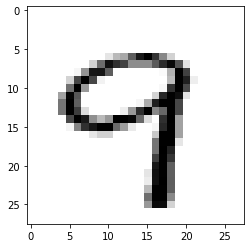

In [ ]:

train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


# Defining Model Architecture

Here we define the convolution blocks and the forward function.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),  #Input-28x28x1 | Output-26x26x16 | RF -3x3
            nn.ReLU()
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),  #Input-26x26x16 | Output-24x24x16 | RF - 5x5
            nn.ReLU()
        ) 

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),  #Input-24x24x16 | Output-22x22x16 | RF - 7x7
            nn.ReLU()
        ) 

        self.pool1 = nn.MaxPool2d(2, 2)  #Input-22x22x16 | Output-11x11x16 | RF - 8x8

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input-11x11x16 | Output-9x9x16 | RF - 12x12
            nn.ReLU()
        ) 

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input-9x9x16 | Output-7x7x16 | RF - 16x16
            nn.ReLU()
        ) 
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input-7x7x16 | Output-5x5x16 | RF - 20x20
            nn.ReLU()
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), #Input-5x5x16 | Output-5x5x10 | RF - 24x24
            nn.ReLU()
        )

        self.pool2 = nn.AdaptiveAvgPool2d(1) #Input-5x5x10 | Output-1x1x10 
        


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Parameters

We print the model parameters by giving dummy input to torchsummary

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 12, 24, 24]           1,080
              ReLU-4           [-1, 12, 24, 24]               0
            Conv2d-5           [-1, 12, 22, 22]           1,296
              ReLU-6           [-1, 12, 22, 22]               0
         MaxPool2d-7           [-1, 12, 11, 11]               0
            Conv2d-8             [-1, 16, 9, 9]           1,728
              ReLU-9             [-1, 16, 9, 9]               0
           Conv2d-10             [-1, 16, 7, 7]           2,304
             ReLU-11             [-1, 16, 7, 7]               0
           Conv2d-12             [-1, 16, 5, 5]           2,304
             ReLU-13             [-1, 16, 5, 5]               0
           Conv2d-14             [

# Training and Testing Functions

Here we define the train and test functions and also the progress bar.

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Code Execution

Final code execution.
Also define stepLR for later use.

In [ ]:
#from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.299438953399658 Batch_id=468 Accuracy=9.91: 100%|██████████| 469/469 [00:10<00:00, 43.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3007, Accuracy: 1009/10000 (10.09%)

EPOCH: 1


Loss=0.5061450004577637 Batch_id=468 Accuracy=54.33: 100%|██████████| 469/469 [00:10<00:00, 43.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3235, Accuracy: 9009/10000 (90.09%)

EPOCH: 2


Loss=0.10874661058187485 Batch_id=468 Accuracy=93.74: 100%|██████████| 469/469 [00:10<00:00, 42.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1551, Accuracy: 9504/10000 (95.04%)

EPOCH: 3


Loss=0.08587191253900528 Batch_id=468 Accuracy=95.76: 100%|██████████| 469/469 [00:10<00:00, 43.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1035, Accuracy: 9686/10000 (96.86%)

EPOCH: 4


Loss=0.03896581381559372 Batch_id=468 Accuracy=96.72: 100%|██████████| 469/469 [00:11<00:00, 41.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0902, Accuracy: 9721/10000 (97.21%)

EPOCH: 5


Loss=0.02823457680642605 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:10<00:00, 42.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0747, Accuracy: 9780/10000 (97.80%)

EPOCH: 6


Loss=0.1043223962187767 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:11<00:00, 41.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0711, Accuracy: 9790/10000 (97.90%)

EPOCH: 7


Loss=0.03552712872624397 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:11<00:00, 39.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0699, Accuracy: 9786/10000 (97.86%)

EPOCH: 8


Loss=0.017510835081338882 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:11<00:00, 41.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 9824/10000 (98.24%)

EPOCH: 9


Loss=0.05474520102143288 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:10<00:00, 43.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9806/10000 (98.06%)

EPOCH: 10


Loss=0.1915581375360489 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:11<00:00, 41.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9823/10000 (98.23%)

EPOCH: 11


Loss=0.10376304388046265 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:11<00:00, 41.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9839/10000 (98.39%)

EPOCH: 12


Loss=0.017273418605327606 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:10<00:00, 44.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9850/10000 (98.50%)

EPOCH: 13


Loss=0.01050418708473444 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:11<00:00, 42.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9863/10000 (98.63%)

EPOCH: 14


Loss=0.02863350510597229 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:11<00:00, 42.51it/s]



Test set: Average loss: 0.0421, Accuracy: 9873/10000 (98.73%)



# Print graph for train and test accuracy

Text(0.5, 1.0, 'Test Accuracy')

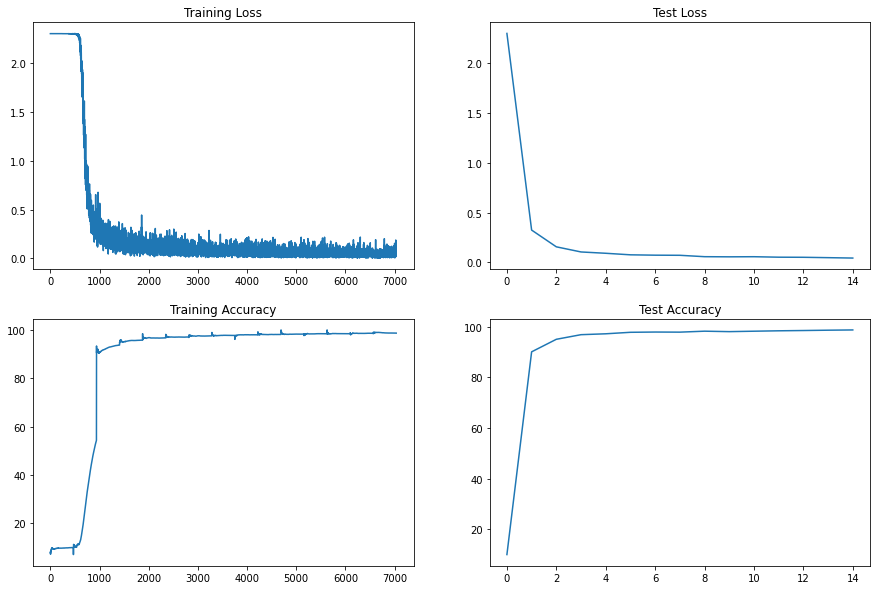

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")